In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def get_tail(vect):
    probs, bin_edges = np.histogram(vect,bins=20,density=False)
    tail = np.cumsum(probs[::-1])[::-1]/vect.shape[0]
    return tail,bin_edges

In [3]:
def get_rep_time(times):
    return times.reshape(int(times.shape[0]/num_rep),num_rep).min(1).max(0)

In [4]:
def check_soln(A,b):
    return np.linalg.matrix_rank(A) == np.linalg.matrix_rank(np.concatenate([A,b],1))

In [5]:
def check_rank(A):
    return np.linalg.matrix_rank(A) == A.shape[1]

In [6]:
def get_worker_rows(worker_num,start_time,max_num):
    worker_dict = {}
    ind_vect = np.delete(np.arange(num_workers),worker_num)
    np.random.shuffle(ind_vect)
    for ctr in range(0,max_num,sr_deg):
        if ctr == 0:
            time_key = start_time + comp_time
            worker_dict[time_key] = np.asarray([worker_num])
        else:
            start_pos = ctr - sr_deg
            end_pos = min(ctr,max_num-1)
            time_key += (end_pos-start_pos)*comp_time
            worker_dict[time_key] = ind_vect[start_pos:end_pos]
    return worker_dict

In [7]:
def sr_simulator(times,max_num):
  
    worker_dicts_list = [get_worker_rows(worker_num,times[worker_num],max_num) for worker_num in range(num_workers)]
    worker_dict_all = {key: val for worker_dict in worker_dicts_list for key, val in worker_dict.items()}
    b = np.ones(num_workers).reshape((-1,1))
    A = None
    cc_flag = False
    one_flag = False
    rank_flag = False
    time_list = sorted(worker_dict_all.keys())
    time_ind = 0

    #Collecting All Rows
    while not cc_flag:
        time = time_list[time_ind]
        v = np.zeros((1,num_workers))
        v[0][worker_dict_all[time]] = 1
        if A is None:
            A = v
            A_sum = v
        else:
            A = np.concatenate([A,v],0)
            A_sum += v  
        cc_flag = np.all((A_sum > 0))
        time_ind += 1  

    if not cc_flag:
        print ('CC ERROR')
        return

    cc_ind = time_ind - 1
    cc_time = time_list[cc_ind]
  
    #Spanning all 1s vector
    while not one_flag:
        time = time_list[time_ind]
        v = np.zeros((1,num_workers))
        v[0][worker_dict_all[time]] = 1
        A = np.concatenate([A,v],0)
        one_flag = check_soln(A.T,b)
        time_ind += 1 
  
    if not one_flag:
        print ('ONE ERROR')
        return
    
    one_ind = time_ind - 1
    one_time = time_list[one_ind]

    #Constructing a f.c.r matrix
    while not rank_flag:
        time = time_list[time_ind]
        v = np.zeros((1,num_workers))
        v[0][worker_dict_all[time]] = 1
        A = np.concatenate([A,v],0)
        rank_flag = check_rank(A)
        time_ind += 1 

    if not rank_flag:
        print ('RANK ERROR')
        return

    rank_ind = time_ind - 1
    rank_time = time_list[rank_ind]
  
    return (cc_time,one_time,rank_time), (cc_ind,one_ind,rank_ind)
  

In [8]:
comp_time = 0.005
exp_rate = 0.2
num_workers = 1000
num_trials = 100
sr_deg = 10

In [9]:
max_num_list = [100,400,700,1000]
SR_times = {}
SR_inds = {}

In [10]:
for max_num in max_num_list:
    SR_times[max_num] = []
    SR_inds[max_num] = []
    for trial in range(num_trials):
        if trial % 10 == 0:
            print (trial)
        setup_times = np.random.exponential(scale=1/exp_rate,size=num_workers)
        #Sum-Recovery
        time_tuple, ind_tuple = sr_simulator(setup_times,max_num)
        SR_times[max_num].append(time_tuple)
        SR_inds[max_num].append(ind_tuple)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


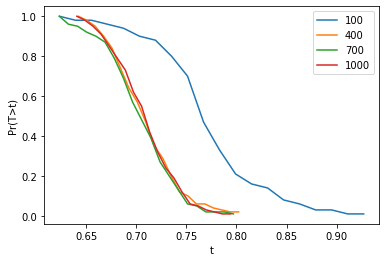

In [11]:
plt.figure()
for key in SR_times:
    tail,bin_edges = get_tail(np.asarray([time_tuple[1] for time_tuple in SR_times[key]]))
    plt.plot(bin_edges[:-1],tail,label=key)
plt.xlabel('t')
plt.ylabel('Pr(T>t)')
plt.legend()
plt.show()

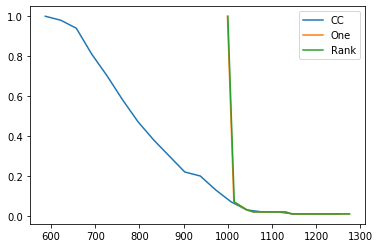

In [12]:
num_tails = {}
plt.figure()
cc_tail, bin_edges = get_tail(np.asarray([code_tuple[0] for code_tuple in SR_inds[1000]]))
plt.plot(bin_edges[:-1],cc_tail,label='CC')
one_tail, bin_edges = get_tail(np.asarray([code_tuple[1] for code_tuple in SR_inds[1000]]))
plt.plot(bin_edges[:-1],one_tail,label='One')
rank_tail, bin_edges = get_tail(np.asarray([code_tuple[2] for code_tuple in SR_inds[1000]]))
plt.plot(bin_edges[:-1],rank_tail,label='Rank')
plt.legend()
plt.show()

In [13]:
with open('SR_times_exp.pkl', 'wb') as f:
    pickle.dump(SR_times, f)

In [14]:
with open('SR_inds_exp.pkl', 'wb') as f:
    pickle.dump(SR_inds, f)

In [15]:
max_num_list = [100,400,700,1000]
SR_times = {}
SR_inds = {}

In [16]:
for max_num in max_num_list:
    SR_times[max_num] = []
    SR_inds[max_num] = []
    for trial in range(num_trials):
        if trial % 10 == 0:
            print (trial)
        setup_times = 1.0+np.random.pareto(a=1,size=num_workers)
        #Sum-Recovery
        time_tuple, ind_tuple = sr_simulator(setup_times,max_num)
        SR_times[max_num].append(time_tuple)
        SR_inds[max_num].append(ind_tuple)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


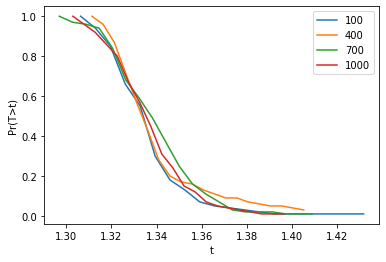

In [17]:
plt.figure()
for key in SR_times:
    tail,bin_edges = get_tail(np.asarray([time_tuple[1] for time_tuple in SR_times[key]]))
    plt.plot(bin_edges[:-1],tail,label=key)
plt.xlabel('t')
plt.ylabel('Pr(T>t)')
plt.legend()
plt.show()

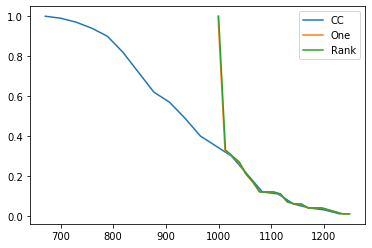

In [18]:
num_tails = {}
plt.figure()
cc_tail, bin_edges = get_tail(np.asarray([code_tuple[0] for code_tuple in SR_inds[1000]]))
plt.plot(bin_edges[:-1],cc_tail,label='CC')
one_tail, bin_edges = get_tail(np.asarray([code_tuple[1] for code_tuple in SR_inds[1000]]))
plt.plot(bin_edges[:-1],one_tail,label='One')
rank_tail, bin_edges = get_tail(np.asarray([code_tuple[2] for code_tuple in SR_inds[1000]]))
plt.plot(bin_edges[:-1],rank_tail,label='Rank')
plt.legend()
plt.show()

In [19]:
with open('SR_times_par.pkl', 'wb') as f:
    pickle.dump(SR_times, f)

In [20]:
with open('SR_inds_par.pkl', 'wb') as f:
    pickle.dump(SR_inds, f)